In [4]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')
mpl.rcParams['pdf.fonttype'] = 42

# import

In [5]:
dataVis108_AL35 = wfOpto(Path(r'Y:\Subjects\AL_0035\2025-01-08\1'))

In [ ]:
dataVis1209_AL35 = wfOpto(Path(r'Y:\Subjects\AL_0035\2024-12-09\1'))

In [ ]:
# linearity test
path = Path(r'Y:/Subjects/AL_0035/2024-12-09/2')
exp2Contrasts = np.load(path / 'linTestContrasts.npy')
exp2Dur = np.load(path / 'linTestDurations.npy')
exp2On = np.load(path / 'linTestOnTimes.npy')
exp2Off = np.load(path/ 'linTestOffTimes.npy')

# analysis functions

## extracting parameters

In [6]:
def getParams(ca_en, en, expStartStop, laserOnTimes, laserOffTimes, gx, gy, laserAmp):
    """
    ca_en - master folder 
    en - experiment folder that you wish to reference
    the following are loaded in from a dataset
        expStartStop = np.load(expdir / 'expStartStopTimes.npy')
        gx = np.squeeze(np.load(expdir / 'galvoXPositions.npy'))
        gy = np.squeeze(np.load(expdir / 'galvoYPositions.npy'))
        laserAmp = np.squeeze(np.load(expdir / 'laserPowers.npy'))
        laserOnTimes = np.squeeze(np.load(expdir / 'laserOnTimes.npy'))
        laserOffTimes = np.squeeze(np.load(expdir / 'laserOffTimes.npy'))
    """
    this_en = en - ca_en - 1 # find the folder that you want. folders are bumped up, so must subtract the master (ca_en) and 1
    start, stop = expStartStop[this_en] # get the start and stop times of the experiment
    e1 = np.squeeze(np.argwhere(laserOnTimes > start)) # find the indices of the laserOnTimes that are greater than the start time
    e2 = np.squeeze(np.argwhere(laserOnTimes < stop)) # find the indices of the laserOnTimes that are less than the stop time

    these_entries = np.intersect1d(e1, e2) # find the indices that are in both e1 and e2
    exp = collections.namedtuple('experiment', ['galvoX', 'galvoY', 'laserAmp', 'laserOn', 'laserOff']) # create a named tuple
    thisExp = exp(gx[these_entries], gy[these_entries], laserAmp[these_entries], 
                  laserOnTimes[these_entries], laserOffTimes[these_entries])
    return thisExp

## baseline and trial t-test

In [7]:
def ttestpowquant(data,galvoX,galvoY,baseline_ind,test_ind,start=-.3,end=0.1,width=30,x=120,y=380,trialtrs=29,t=1350):
    #my indices 
    n_samples = round((end-start) * 35)
    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    galvoX=np.argwhere(data.galvoX[:t]==galvoX).ravel()
    galvoY=np.argwhere(data.galvoY[:t]==galvoY).ravel()
    loc=np.intersect1d(galvoX,galvoY)

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    powers=np.unique(data.laserPowers)

    #checkers
    baselines=[]
    activities=[]

    for i,pow in enumerate(powers):

        #get our trial activity for both baseline period and stim period 
        pwTrs = np.argwhere(data.laserPowers[:t] == pow).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity[:trialtrs])

        #get my threshold
        baselines.append(trial_activity[:,:baseline_ind])
        activities.append(trial_activity[:,test_ind:])
    baselines = np.mean(baselines,axis=2)
    activities=np.mean(activities,axis=2)
    return scipy.stats.ttest_rel(baselines,activities,axis=1), baselines, activities

# a

image of the brain after a laser is shone on the front of the brain

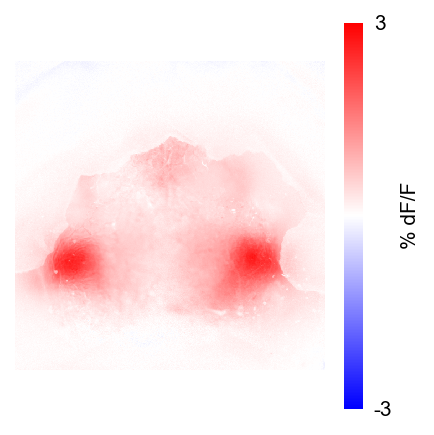

In [13]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
data=dataVis108_AL35
power=2
galvoX=0;galvoY=0;start=0;end=1
frame=5
vmax=0.030
vmin=-0.030
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
im = ax.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
cbar=plt.colorbar(im,ax=ax,location='right')
cbar.set_ticks([-0.03,0.03])
cbar.set_ticklabels(['-3','3'])
cbar.ax.tick_params(size=0)

cbar.outline.set_visible(False)
cbar.set_label('% dF/F')

# b

trace of visresp to laser

([], [])

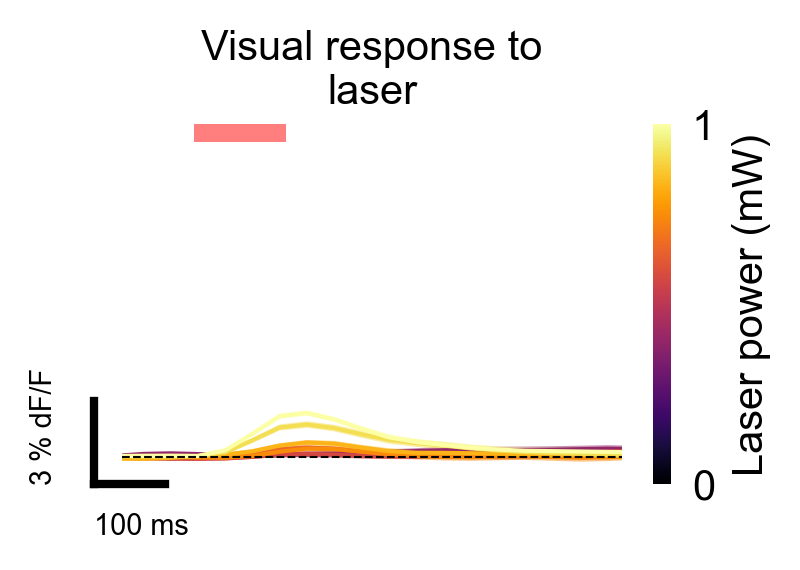

In [36]:
data=dataVis108_AL35
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=120;y=380;width=15;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1980
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

meanim = data.meanImage.reshape(560*560,-1)
meanroi = meanim[flat_indices]

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        mov = mov + meanroi # adding back the mean from the session to get to true 'raw'
        mov_area_avg = np.mean(mov,axis=0) #avg over the 900 pixels
        mov_abs = mov_area_avg + np.abs(np.min(mov_area_avg))
        baseline_mean = np.mean(mov_abs[0:7])
        dff = (mov_abs - baseline_mean) / baseline_mean
        trial_activity.append(dff)
    pxPowers.append(np.mean(trial_activity,axis=0))
    sems.append(scipy.stats.sem(trial_activity,axis=0))

fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]
ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.130,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.03 # length of dff bar
x_start = 0 - 0.14 # where the bar should start
y_start = -0.01 # where the bar should start

plt.ylim([-.01,.12])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# c

linearity test

In [ ]:
data=dataVis1209_AL35
x=120
y=415
width=15
colors_grey = plt.cm.Greys(np.linspace(0.2,1,5))

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
pxCon=[]
sems=[]
start=-0.2
end=1
n_samples=round((start*-1+end)*35)
for contrast in np.unique(exp2Contrasts):
    contrs = np.argwhere(exp2Contrasts==contrast).ravel()
    onTimes = exp2On[contrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxCon.append(np.mean(trial_activity,axis=0))
fig,ax=plt.subplots(figsize=(3,2),dpi=300)

times=np.linspace(start,end,n_samples)
for iC,contrast in enumerate(pxCon):
    print(len(contrast))
    plt.plot(times,contrast,color=colors_grey[iC])
    plt.fill_between(times, \
            contrast-sems[iC],\
            contrast+sems[iC], color=colors_grey[iC],label='_nolegend_',alpha=.5,linewidth=0)
plt.axvspan(0,.130,ymin=0.92,ymax=0.97,color='grey',alpha=0.5,lw=0)

cm = mpl.cm.ScalarMappable(cmap='Greys') # creates a color mapping objec
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7:.1f} mW') # the power variable is in V (taken from data npys)
cbar=plt.colorbar(ax=ax,mappable=cm,label='Stimulus contrast') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)
plt.title('Visual response to\nexternal stimuli')

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.03 # length of dff bar
x_start = 0 - 0.25 # where the bar should start
y_start = -0.018 # where the bar should start
plt.ylim([-.01,.12])
plt.axhline(0, xmin=0.2,xmax=4,color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.xticks([])
plt.yticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)